In [1]:
# En un problema de regresion, la salida es un numero
# Este es un problema de clasificacion, por lo tanto, el problema 
    # tiene tantas salidas como categorias tengamos

# Como le damos como entrada una imagen??
# Tomamos una imagen, y le damos un valor numerico a cada pixel
    # 0 es negro y 255 es blanco
# Lo ideal es reducir la imagen a un tamaño menor con tal de que se vea
    # pixelado pero que se alcance a ver la forma
    # por ejemplo 28x28px = 784px = Entradas del modelo

# Que tipo de red neuronal vamos a usar?
# La que se usa para clasificacion de imagenees es la RN CONVOLUCIONAL

# Pero aca partiremos de una RN DENSA normal
# Una RN Densa con solo pesos y cesgos, solo puede resolver problemas lineales
    # pero si se le agrega a cada salida una FUNCION DE ACTIVACION f(x)
    # por ejemplo la funcion ReLU, 
    # (funcion que si la salida > 0 entonces salida, sino 0)
    # se puede hacer que se resuelvan problemas no lineales

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds # Dataset con imagenes de ropa 28x28

In [3]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\fashion_mnist\3.0.1.incompleteS36IP7\fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\fashion_mnist\3.0.1.incompleteS36IP7\fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [4]:
metadatos # 60000 datos de entrenamiento, 10000 de prueba

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='~\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      autho

In [29]:
# Separamos los datos de entrenamiento y prueba
# los nombres train y test estan especificados mas arriba
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [30]:
# Buscamos las clasificaciones, o salidas
nombres_clases = metadatos.features['label'].names
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [31]:
# Normalmente hay que NORMALIZAR los datos 
# (hacer que todas las entradas sean entre 0 y 1)
# sino los datos de entrada estarian entre 0 y 255
# esto hace que se mejore el entrenamiento y se aceleren los resultados

def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255
    return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregar los datos a cache (usar memoria en lugar de disco)
# entrenamiento mas rapido
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

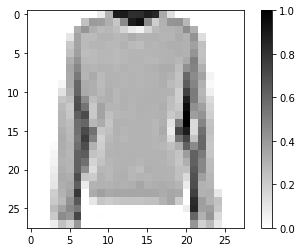

In [32]:
# Mostrar una imagen de los datos de prueba, por ahora solo la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
    break
# La imagen en este caso es un array de 784, por eso lo reshapeamos a 28x28
imagen = imagen.numpy().reshape((28,28)) #Redimensionar

import matplotlib.pyplot as plt

# Dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

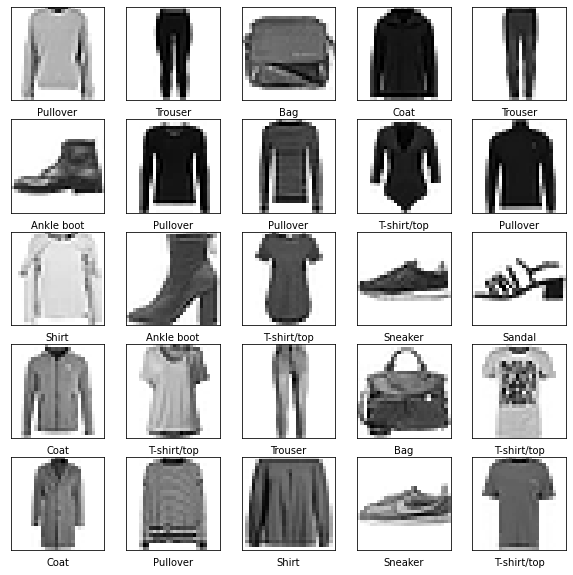

In [33]:
plt.figure(figsize=(10,10))
for i, (imagen,etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel(nombre_clases[etiqueta])
plt.show()

# Aca arranca el modelo

In [34]:
# Creamos el modelo RN DENSA
modelo = tf.keras.Sequential([
    # Flatten aplasta el conjunto de datos (si fuera una matriz)
    tf.keras.layers.Flatten(input_shape=(28,28,1)), # Entrada
    tf.keras.layers.Dense(50, activation=tf.nn.relu),# Capa oculta con f(x) ReLU
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)# Salida con f(x) Softmax
                          # Esta f(x) se usa para RN de Clasificacion
])

In [35]:
# Compilar el modelo
modelo.compile(
    optimizer='adam',
    # Al igual que softmax, esta Sparse... se usa en RN de Clasificacion
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [36]:
# Agarramos como variable el numero de ejemplos de entrenamiento
num_ej_entrenamiento = metadatos.splits['train'].num_examples
num_ej_pruebas = metadatos.splits['test'].num_examples

In [37]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [38]:
# Para hacer que la red entrene mas rapido, se puede separar en LOTES
TAMANO_LOTE = 32

# Como daremos varias vueltas al set de datos en el entrenamiento
# queremos que se haga de manera aleatoria y no siempre en el mismo orden
# A shuffle hay que especificarle cuantos son los datos que queres mezclar
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [39]:
# Entrenamiento

import math

historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

# En cada vuelta podemos ver la precision (accuracy)
# Idealmente hay que terminar con una precision de alrededor .88


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5169 - accuracy: 0.8198
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3798 - accuracy: 0.8615
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3463 - accuracy: 0.8738
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3212 - accuracy: 0.8818
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3077 - accuracy: 0.8871


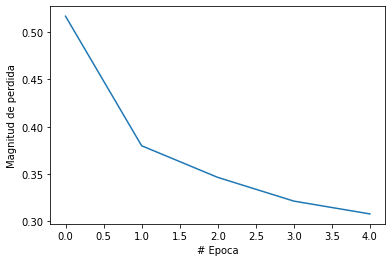

In [40]:
# Resultado de funcion de perdida en cada epoca
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de perdida')
plt.plot(historial.history['loss'])

1/1 [==============================] - 0s 47ms/step


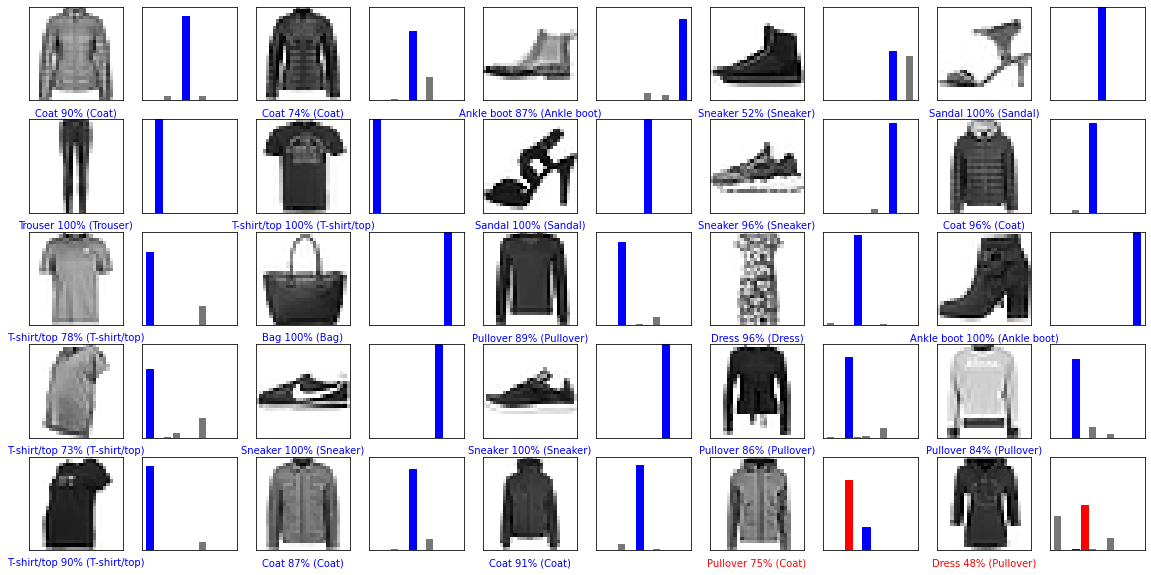

In [41]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [42]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] 
# AL ser la variable imagenes_prueba solo tiene lo que se 
# le puso en el bloque anterior
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 60ms/step
Prediccion: Sandal


# Conclusion

In [ ]:
'''
  Las redes neuronales como esta (DENSA) son buenas para resolver problemas de
regresion y clasificacion donde los datos de entrada no cambian de posicion,
es decir, aqui las imagenes siempre van a estar centradas y puestas en vertical,
Asi lo aprende el modelo.
Pero que pasaria si giramos, agrandamos o descentramos una imagen?? 
el modelo dejaria de ser funcional.
Debido a estas limitantes es por lo que se inventaron las RN CONVOLUCIONALES
que no aprenden las posiciones de las entradas, sino que realmente intente
entender lo que esta viendo.
'''

# Exportar modelo para TensorflowJS

In [43]:
#Exportacion del modelo a h5
modelo.save('modelo_exportado.h5')

In [44]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3


In [45]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

2022-07-01 00:47:35.457227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-07-01 00:47:35.457304: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [48]:
#Veamos si si creo la carpeta
!dir

 El volumen de la unidad C es OS
 El n£mero de serie del volumen es: F82B-8EEE

 Directorio de C:\Users\jeres\Documents\Curso Data Scientist

01/07/2022  00:48    <DIR>          .
29/06/2022  19:49    <DIR>          ..
30/06/2022  23:30    <DIR>          .ipynb_checkpoints
16/05/2022  20:41    <DIR>          Clase 1
06/06/2022  20:44    <DIR>          Clase 10 Herramientas de Visualizacion
06/06/2022  22:12    <DIR>          Clase 11 Procesamiento de Datos
08/06/2022  22:20    <DIR>          Clase 12 Introduccion al analisis predictivo con regresion
27/06/2022  22:31    <DIR>          Clase 17 Modelo Analitico 2
20/05/2022  20:14    <DIR>          Clase 2
20/05/2022  20:14    <DIR>          Clase 3
20/05/2022  20:16    <DIR>          Clase 4 Numpy
16/05/2022  22:16    <DIR>          Clase 5 Pandas
08/06/2022  21:39    <DIR>          Clase 6 Pandas II
25/05/2022  21:52    <DIR>          Clase 7 Visualizaciones
08/06/2022  21:37    <DIR>          Clase 8 Visualizaciones II
08/06/2022  20

C:\Users\jeres\Documents\Curso Data Scientist
